# Capstone 3 Project: Spotify <br>
Music is a massive industry, with artists all over the world constantly vying to know how to best cater to their fans, build their brand, and remain relevant. In this project, we will be exploring data pertaining to a particular music producer and DJ by the artist name of Illenium. The idea will be to analyze how the music from Illenium compares to other artists within similar genres. This analysis will then be used to build models to see what features of songs are the most popular to spotify listeners (within the genre) and generate suggestions for what features to implement into songs in the future. The main stakeholders will be Nicholas Miller (Artist) and Sean Flynn (Artist Management).

<br><br>For Reference Here are links to [Spotify API Documentation](https://developer.spotify.com/documentation/web-api/reference/#category-personalization) and [Spotipy Documentation](https://spotipy.readthedocs.io/en/2.19.0/)

In this portion of the project we will be using a python module called Spotipy, which is essentially an extension of the spotify API for python projects. This will allow us to pull in our desired data from spotify!

In [1]:
import spotipy
import pandas as pd
import matplotlib.pyplot as plt
from spotipy.oauth2 import SpotifyClientCredentials
cid = '**HIDDEN**'
secret = '**HIDDEN**'

client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

Grab the 20 closest related artists to Illenium

In [2]:
illenium = 'spotify:artist:45eNHdiiabvmbp4erw26rg'
myArtists = sp.artist_related_artists(illenium)

ids for all of these artists including illenium

In [3]:
list_artist_ids = [artist['id'] for artist in myArtists['artists']]
list_artist_ids.append(illenium.split(":")[2])

for each of our artists, we will collect a dataframe for their top 10 current songs

In [4]:
for artistId in list_artist_ids:
    globals()['test_%s' % artistId] = pd.DataFrame.from_dict(sp.artist_top_tracks(artistId, country='US')['tracks'], orient='columns')

Combine all 11 dataframes into a single dataframe

In [5]:
frames = [globals()['test_%s' % artistId] for artistId in list_artist_ids]
track_df = pd.concat(frames)
track_df.shape

(210, 17)

---------
Here we are pulling in extra features for each song. We will pull all of our song ids and grab the features from a different table within the API

In [6]:
#in order to get audio_features, we have to give it a list that has a size of 100 or less.... this cell accomplishes this
track_ids = list(track_df['id'])

#this function will split our original list into a size of n, the idea will be to create some nested lists
def chunk_list(lst, n):
    for x in range(0, len(lst), n):
        each_chunk = lst[x: n+x]

        if len(each_chunk) < n:
            each_chunk = each_chunk + [None for y in range(n-len(each_chunk))]
        yield each_chunk

a, b, c = chunk_list(track_ids, 70)
features0 = sp.audio_features(tracks=a)
features1 = sp.audio_features(tracks=b)
features2 = sp.audio_features(tracks=c)

all_features = features0 + features1 + features2

Here we create a features dataframe and we will subsequently merge it to our track_df from earlier

In [7]:
features_df = pd.DataFrame(all_features[0], index=[0])

for i in range(len(all_features)):
    features_df = features_df.append(all_features[i], ignore_index=True)

In [8]:
df = pd.merge(track_df, features_df, how="left",on='id')

Our Column for Artists contained a dictionary of all of the information related to all of the artists for the different tracks (in this particular Genre, it is frequent that the producer will bring on a feature artist, so typically there are multiple artists). This cell simply takes the names of all artists and places them in a string

In [9]:
for i in range(len(df['artists'])):
    artists_string = ''
    for item in df.loc[i,'artists']:
        artists_string += item.get('name') + ', '
    df.loc[i,'artists'] = artists_string[:-2]

Here we drop any columns or rows that are deemed unnecessary. Reasons for dropping this information ranges from containing null value (1 row) or the deleted features are unimportant and would simply add noise

In [10]:
delete_cols = ['album', 'disc_number', 'duration_ms_x', 'explicit', 'external_ids', 'external_urls','href','is_local','is_playable','preview_url','track_number','type_x','uri_x','type_y','uri_y','track_href','analysis_url','duration_ms_y']
df = df.drop(columns=delete_cols).drop_duplicates()
df = df.loc[~df['energy'].isnull(), :]

Below is our cleaned dataset that we will be analyzing through the remainder of the project, sorted by popularity

In [11]:
df.sort_values(by='popularity',ascending=False).head(30)

,artists,id,name,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
212,"The Chainsmokers, ILLENIUM, Lennon Stella",3g0mEQx3NTanacLseoP0Gw,Takeaway,76,0.528,0.511,3.0,-8.144,1.0,0.0324,0.126000,0.000000,0.1010,0.3510,100.100,4.0
192,"NGHTMRE, SLANDER, Matthew Santos",0suLmBuEbatdochI4tHduq,FEELING GUD,70,0.484,0.940,5.0,-3.682,0.0,0.2570,0.014500,0.000323,0.2660,0.3340,173.741,4.0
215,"ILLENIUM, Tori Kelly",1suqXPrYygZ7BYiSfaVZE4,Blame Myself,69,0.416,0.675,8.0,-6.109,1.0,0.0821,0.050400,0.000140,0.2650,0.3890,140.129,4.0
214,"Gryffin, ILLENIUM, Daya",0Ev562zA4pmUsBqjxsxxdx,Feel Good (feat. Daya),69,0.625,0.707,2.0,-4.761,1.0,0.0337,0.220000,0.000000,0.2130,0.4790,138.064,4.0
219,"ILLENIUM, X Ambassadors",70YPzqSEwJvAIQ6nMs1cjY,In Your Arms (with X Ambassadors),66,0.404,0.806,2.0,-4.750,1.0,0.0496,0.198000,0.000000,0.1140,0.1120,148.036,4.0
140,INZO,4K9xid96G3YmIvQZXN9SXg,Overthinker,66,0.472,0.605,8.0,-4.437,1.0,0.1340,0.031100,0.030800,0.1010,0.2120,128.375,1.0
150,"Zeds Dead, MKLA",5bFuHlXKw66Uu2cHKn5bf8,Alive,65,0.618,0.758,8.0,-7.996,1.0,0.0336,0.008700,0.102000,0.1470,0.1440,120.987,4.0
67,Slushii,1gAPybZsQhhr7L8WgDneyj,All I Need,65,0.820,0.948,4.0,-3.154,1.0,0.0920,0.003740,0.943000,0.0680,0.5510,123.991,4.0
220,"ILLENIUM, Jon Bellion",3LxG9HkMMFP0MZuiw3O2rF,Good Things Fall Apart (with Jon Bellion),64,0.643,0.603,2.0,-5.416,1.0,0.0311,0.012000,0.000000,0.1180,0.4200,144.010,4.0
88,"Gryffin, Seven Lions, Noah Kahan",1vsQb8n0icvMsFnL9663LM,Need Your Love (with Noah Kahan),63,0.581,0.760,0.0,-3.962,1.0,0.0406,0.160000,0.000000,0.1830,0.5230,104.099,4.0


all of our datas information. artists, id, and name can be dropped for any modeling, the rest look to be clean and ready to go.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203 entries, 0 to 223
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artists           203 non-null    object 
 1   id                203 non-null    object 
 2   name              203 non-null    object 
 3   popularity        203 non-null    int64  
 4   danceability      203 non-null    float64
 5   energy            203 non-null    float64
 6   key               203 non-null    float64
 7   loudness          203 non-null    float64
 8   mode              203 non-null    float64
 9   speechiness       203 non-null    float64
 10  acousticness      203 non-null    float64
 11  instrumentalness  203 non-null    float64
 12  liveness          203 non-null    float64
 13  valence           203 non-null    float64
 14  tempo             203 non-null    float64
 15  time_signature    203 non-null    float64
dtypes: float64(12), int64(1), object(3)
memory u

Although we don't have any null values, the below cell shows the distributions for all of our numeric features. Looking forward to the remainder of the project!

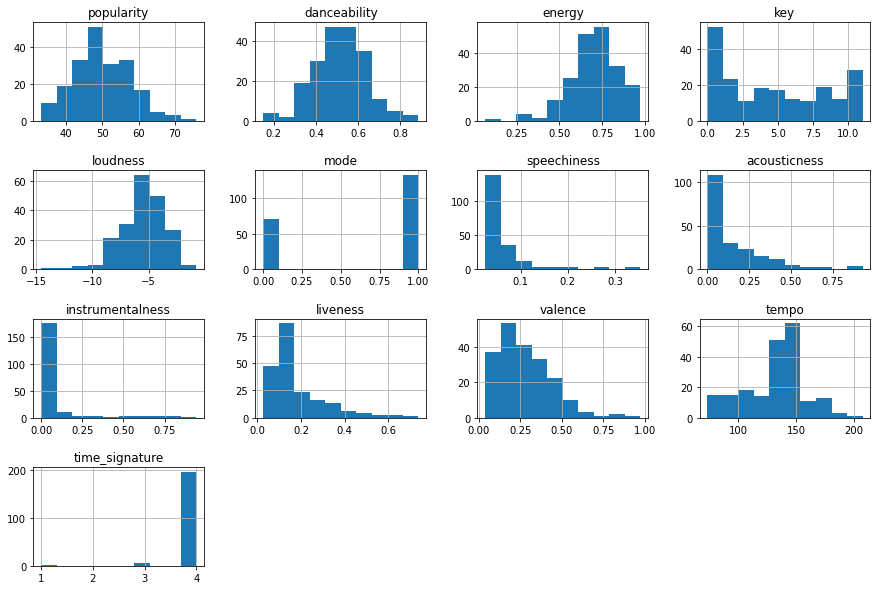

In [13]:
df.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5)

In [14]:
df.to_csv('all_tracks_capstone3.csv')